In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import collections

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss, log_loss, auc

import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('adult.data.csv')

# Dataset Adult, Description

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlwgt          32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   50K             32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We see that there is numerical features that possible can related to the binary target salary (50K column), they are:
 - capital-gain, capita-loss, hours-per-week and age.
 - fnlwgt is a numerical feature which the description is not given nor intuitive from the name.
 
Also, there is a bunch of socio-demographic features which we may try to see the importance from simple descriptive analysis.

## Looking for missing values

Use the function isnull to account for the total missing values and by column.

In [6]:
# total 
data.isnull().sum().sum()

0

In [7]:
# by column
data.isnull().sum()

age                0
 workclass         0
 fnlwgt            0
 education         0
 education-num     0
 marital-status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 capital-gain      0
 capital-loss      0
 hours-per-week    0
 native-country    0
 50K               0
dtype: int64

Good, this dataset is free of missing values. But still there can be miss-registration, outliers, we try treat this below by checking the histogram of the values.

## Description of categorical by counting

First we see if the categories of features are equally represented in the dataset.

Then we see if there is a relation of the categorical features to the target salary column by counting the proportion inside each category of the features.

In [8]:
names = [' workclass',' education',' marital-status',' occupation',' relationship',' race',' sex',' native-country',' 50K']
dfcategorical = data[names]
dfcategorical.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,50K
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [9]:
print(dfcategorical[' workclass'].value_counts())
print(dfcategorical[' education'].value_counts())
print(dfcategorical[' marital-status'].value_counts())
print(dfcategorical[' occupation'].value_counts())
print(dfcategorical[' relationship'].value_counts())
print(dfcategorical[' sex'].value_counts())
print(dfcategorical[' native-country'].value_counts())

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name:  workclass, dtype: int64
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name:  education, dtype: int64
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name:  marital-status, dtype: int64
 Prof-specialty       4140
 Craft-repair         4099
 Exec-manager

In most of features the categories are not equally represented. In the feature occupation, however, there are some of then with similar counts

Now we can examine the proportions of the salary target variable for each category

In [10]:
print(dfcategorical.groupby(' occupation')[' 50K'].value_counts(normalize=True))
print(dfcategorical.groupby(' marital-status')[' 50K'].value_counts(normalize=True))
print(dfcategorical.groupby(' sex')[' 50K'].value_counts(normalize=True))
print(dfcategorical.groupby(' education')[' 50K'].value_counts(normalize=True))


 occupation          50K  
 ?                   <=50K    0.896365
                     >50K     0.103635
 Adm-clerical        <=50K    0.865517
                     >50K     0.134483
 Armed-Forces        <=50K    0.888889
                     >50K     0.111111
 Craft-repair        <=50K    0.773359
                     >50K     0.226641
 Exec-managerial     <=50K    0.515986
                     >50K     0.484014
 Farming-fishing     <=50K    0.884306
                     >50K     0.115694
 Handlers-cleaners   <=50K    0.937226
                     >50K     0.062774
 Machine-op-inspct   <=50K    0.875125
                     >50K     0.124875
 Other-service       <=50K    0.958422
                     >50K     0.041578
 Priv-house-serv     <=50K    0.993289
                     >50K     0.006711
 Prof-specialty      <=50K    0.550966
                     >50K     0.449034
 Protective-serv     <=50K    0.674884
                     >50K     0.325116
 Sales               <=50K    0.73068

First we note that, in this sample, the categories Exec-manegerial and Prof-specialty seems to have higher salary.

The other categories are generally less than half richer.

The degree of education also heavily influences the percentage of people receiving more than 50K.

The women are generally less privilegied and the married persons are also richer.

## Categorical

One-hot-encode each categorical variable. Costful operation, it does expands the dataframe according to the number of categories, but necessary because sklearn decision tree algorithm does not support non numerical values.

In [16]:
# With sklearn class you will get a numpy matrix of 1s and 0s as output
# from sklearn.preprocessing import OneHotEncoder

encodedcat = pd.get_dummies(dfcategorical.drop(' 50K',axis=1),prefix=None, prefix_sep="")
encodedcat.columns

Index([' workclass ?', ' workclass Federal-gov', ' workclass Local-gov',
       ' workclass Never-worked', ' workclass Private',
       ' workclass Self-emp-inc', ' workclass Self-emp-not-inc',
       ' workclass State-gov', ' workclass Without-pay', ' education 10th',
       ...
       ' native-country Portugal', ' native-country Puerto-Rico',
       ' native-country Scotland', ' native-country South',
       ' native-country Taiwan', ' native-country Thailand',
       ' native-country Trinadad&Tobago', ' native-country United-States',
       ' native-country Vietnam', ' native-country Yugoslavia'],
      dtype='object', length=102)

In [17]:
numerical = [' fnlwgt',' capital-gain',' capital-loss',' hours-per-week']
xfeatures = data[numerical]

df=pd.concat([xfeatures,encodedcat],join='inner',axis=1)
print(xfeatures.shape)
print(encodedcat.shape)
print(df.shape)

(32561, 4)
(32561, 102)
(32561, 106)


# Decision Trees

Consider a dataset with numerical and categorical features to be classified in a target variable consisting of N classes. Intuitively what a Decision Tree does is to split the samples by choosing a feature value, according to a metrics of how much the samples at each partition partition are of different classes. The algorithm then recursevely splits each partition until some criteria, of stopping, are met.

One metric employed, named Information Gain, uses entropy to measure partitions:

\begin{equation*}
S=-\sum_{i \in |K|} p_{i} log p_{i}
\end{equation*}

Where |K| is the number of classes in the dataset and

\begin{equation*}
IG(F)= S_{p}-\sum_{i \in |Q|} \frac{N_{i}}{N} S_{i}
\end{equation*}

For a set F of choosen features to split the partitions, considering you have |Q| partitions after the split. Since the aim is to choose the split that minimizes entropy $S_{i}$ in the resulting partitions, the algorithm will choose F such that it maximizes IG ( $S_{p}$ is the entropy of the level above.
Gini Impurity is another metric you can choose to minimize. Its results are similar to entropy. 

Some parameters alters the behaviour of the algorithm. They are the criteria to limit the number of features to search and to stop the algorithm from spliting the dataset. In Scikit-learn they are:

- max_features: is the number of randomly selected features to search for the split according to the metric.
- min_samples_split: minimal number of samples per partition.
- max_depth: the deep of the tree, this will limit the number of splits, if it's None the tree will continue until each leaf partition has one class or until each partition has min_samples_split samples. 
- min_samples_leaf: stop splitting an partition that has less than min_samples_leaf samples. 

## Performance metrics 

Here i give a small intro into some fundamental metrics for classification. You may find in scikit-learn documentation [1] brief explanations for a wide range of implemented metrics that may serve for the most common machine learning tasks (clustering, classification, regression). In addition, i used reference [2] as it has a clear explanation for classification, in multclass problems, for such metrics. 

- Accuracy.
- Confusion Matrix.
- Balanced Accuracy.
- Brier Loss.
- Log-Loss (Cross-Entropy).

Classification metrics can be an estimated loss between the predicted probability of the class and the certaint of that class (usually a holdout data from the dataset with known class-label) or it can be an accuracy-type metric, measuring how much of each class the algorithm labeled as being of the right class. 

Thus we see that loss-metrics can be convenient for more sensible access of the algorithm performance, since it does accounts for how much the predicted probability differs from 1.0 for each class, while the accuracy merely assigns 1.0 if the predicted probability for a class is greater than 0.5. 

### Accuracy

As said above, accuracy says how much of each class is rightly labeled by the classifier. With $N$ as the number of observations in the test set, $G$ is the number of classes, $g(.)$ is the classifier and $x$ is a test sample:

\begin{equation}\label{eq:}
accuracy = \frac{1}{N}\sum_{k:k \in |G|}\sum_{x}1(g(x) = k)
\end{equation}

Where $1(.)$ is the indicator function that has value 1.0 for the equality $g(x)=k$ and 0 otherwise. 

It's easy to see how unbalanced datasets are badly measured by this, since $ N = \sum_{i:i \in |G|} |x_{i}|$ the minority classes will vanish and the classifier will over-estimate the accuracy basing itself upon the majority class hits. We will see a simple way to correct this below, by using the class prevalence weights (balancing classes). 

To note, the names True Positive,False Positive, True Negative, False Negative (TP,FP,TN,FN), inherited from statistical analysis, are equivalent to the given above. In binary case, P holds for one class and N for the other, in multiclass one have $P_{i}$ for label pertaining to the class $i$ and $N_{i}$ refer to all other classes. To my point of view the nomenclature is very misleading in the sense that it does not connect the symbols $P$ and $N$ to an unique class, so this logic of nomenclature inherited from statistics does not generalize well from the binary case to the multiclass.

As we will see below, Confusion Matrices are the natural generalization of such metrics, and i personally like the explanation in the scikit-learn documentations [3], its parsimonious and exact, evading dubious symbols like $TP$,$FN$ and so on.

### Confusion Matrix

Here i quote [3]: 

- "By definition a confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.
Thus in binary classification, the count of true negatives is $C_{0,0}$ , false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$."

The first phrase thus extends the metrics to multiclass. We have a whole family of metrics based on the values of the confusion matrix, namely Precision, Recall, F1-Score, Area Under the Curve for Precision vs Recall curves (ROC - AUC), Balanced Accuracy and One vs All (to use Precision and Recall curves for multiclass problem). 
Here i shall ilustrate Balanced Accuracy since it is the simplest and most generalizable option for accuracy based metrics.

### Balanced Accuracy

First lets define Precision (P) and Recall(R) and see it's relation to the class scoring, for a class $i$:

\begin{equation*}
R_{i} = \frac{C_{i,i}}{C_{i,i}+\sum_{j:j \in |G|}C_{i,j}}
\end{equation*}

\begin{equation*}
P_{i} = \frac{C_{i,i}}{C_{i,i}+\sum_{j:j \in |G|}C_{j,i}}
\end{equation*}

\begin{equation*}
P = \sum_{i:i \in |G|}\frac{P_{i}}{|G|}
\end{equation*}

\begin{equation*}
R = \sum_{i:i \in |G|}\frac{R_{i}}{|G|}
\end{equation*}

The Macro-Averaged R (opposed to micro-average, for summing on all classes, in the $R_{i}$ and $P_{i}$ equations, a sum for the numerator and one for the denominator) is also called $balanced$ $accuracy$. 
From $R_{i}$ we see that the numerator $C_{i,i}+\sum_{j:j \in |G|}C_{i,j}$ is the quantity of occurrence of class i in the test set, while $C_{i,i}$ is the amount of correct predicted samples, so that it rebalances the metrics by the weights relative to the size of class in the dataset, resulting in an unbiased metrics.

### Brier Loss

The Brier Loss is one of the simplest comparison of the sample classes to the predicted probability for the class, it works for binary classification.

\begin{equation}
Loss = \frac{1}{N}\sum_{i}(l_{i}-p_{i})^2
\end{equation}

$l_{i}$ is the sample $i$ label (1.0 or 0.0), $p_{i}$ is the probability for the label 1.0.

### Log-Loss (Cross-Entropy)

Cross-entropy loss can be used in any multiclass classification problems, since it has the properties of being non-negative monotonous function, it's interpretation is straight forward and it does become very popular in deep-learning classification tasks.

The concept came from the likelihood concept. First, suppose that your model is the correct model (or the parameter values, or the predicted probability values are correct), then the probability of seeing sample $x$ is $Pr(x|model params or prob)$. The negative log of this probability gets very large as $Pr(.)$ approaches 0.0, meaning its very unlikely the assumed model is a good choice for the observation $x$. When $Pr(.)$ goes to 1.0, however, the negative log goes to 0.0, meaning that the observation can be regarded as being from the model. Thus the negative log likelihood can be regarded as a loss function for the current model in relation to the data (or how much you are missing assuming this model). For a sample in the given dataset with K classes, the likelihood is the following:

\begin{equation*}
Pr(x_{i}|model prob) = \prod_{k \in |K|}p_{i,k}
\end{equation*}

The loss for the whole dataset is:

\begin{equation*}
L= - \frac{1}{N} \sum_{i \in |N|} log Pr(x_{i}|model prob) = - \frac{1}{N} \sum_{i \in |N|} \sum_{k \in |K|}log p_{i,k} = - \frac{1}{N} \sum_{i \in |N|} \sum_{k \in |K|}t_{i,k} log p_{i,k}
\end{equation*}

Where $t_{i,k}$ is equal to 1.0 in the case observation $i$ is in the class $k$ and 0 otherwise. 

### References:
[1] Scikit-Learn Evaluation Metrics - https://scikit-learn.org/stable/modules/model_evaluation.html

[2] Measuring multiclass problems - https://www.datascienceblog.net/post/machine-learning/performance-measures-multi-class-problems/

[3] Confusion Matrix - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

## But the dataset is imbalanced, what to do ? 

In [21]:
ylabel=data[' 50K']

 <=50K    0.75919
 >50K     0.24081
Name:  50K, dtype: float64


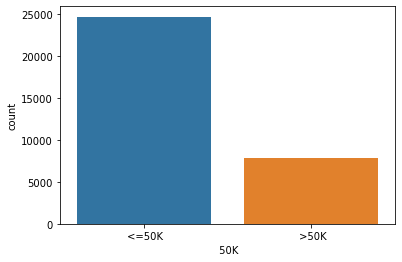

In [22]:
sns.countplot(data[' 50K'])
print(data[' 50K'].value_counts(normalize=True))

Three approachs for dealing with this class imbalance:
- Sampling methods on minority/majority classes and weighting scoring of accuracy according to the imbalance of classes.
- For tree methods (decision trees and random forest), using a split criteria insensitive to imbalance such Hellinger Distance (not implemented yet in sklearn).

### SMOTE oversampling method with balanced accuracy

The SMOTE algorithm selects samples from minority class and create new samples by random sampling a small perturbation and adding to the existing sample. The perturbation is given by a random float between [0,1.0] times the distance of the sample to a nearest neighbor. This way you can bootstrap a minority class to have the same amount of representativity on the target labels.

In [23]:
#Relabeling 
d = {' <=50K':1, ' >50K':0}
ylabel = ylabel.map(d)

In [24]:
oversample = SMOTE()
X,y=oversample.fit_resample(df, ylabel)
X.info()
print(y.value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49440 entries, 0 to 49439
Columns: 106 entries,  fnlwgt to  native-country Yugoslavia
dtypes: int64(4), uint8(102)
memory usage: 6.3 MB
1    0.5
0    0.5
Name:  50K, dtype: float64


In [28]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, y, test_size=0.3,
random_state=17)

y_train.value_counts(normalize=True)

1    0.502398
0    0.497602
Name:  50K, dtype: float64

## Fitting and Cross-Validation

In [30]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=None,min_samples_leaf=1, random_state=10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

In [31]:
y_pred=tree.predict(X_holdout)

print('Model Accuracy Score')
print(accuracy_score(y_holdout,y_pred))
print('Model Balanced Accuracy Score')
print(balanced_accuracy_score(y_holdout,y_pred))

Model Accuracy Score
0.868797195253506
Model Balanced Accuracy Score
0.8687430245483706


The score are the same and we see the effectiveness of the SMOTE balancing algorithm

Next we use scikit-learn grid search around tree parameters, performing 10-fold cross-validation for each 3-tuple of the grid of parameters.

In [33]:
tree_params = {'max_depth': range(1,11),
               'max_features': range(2,5),
               'ccp_alpha': [0.0,0.005,0.007,0.009]
              }

tree_grid = GridSearchCV(tree, tree_params,
                         cv=10, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   18.2s finished


GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=10),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.005, 0.007, 0.009],
                         'max_depth': range(1, 11),
                         'max_features': range(2, 5)},
             verbose=True)

In [34]:
print('Best Model Parameters')
print(tree_grid.best_params_)
print('Best Model Score')
print(tree_grid.best_score_)

ypred=tree_grid.predict(X_holdout)
print('Hold out accuracy')
print(accuracy_score(y_holdout,ypred))
print('Hold out balanced accuracy')
print(balanced_accuracy_score(y_holdout,ypred))

Best Model Parameters
{'ccp_alpha': 0.0, 'max_depth': 8, 'max_features': 4}
Best Model Score
0.7822758048811447
Hold out accuracy
0.7851267529665588
Hold out balanced accuracy
0.7854945321406279


You can plot the fitted model as a tree diagram.

In [16]:
import pydotplus #pip install pydotplus
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

## Feature Importance

In [35]:
importance=pd.DataFrame(columns=['features','importance'])
importance['features']=X.columns
importance['importance']=tree_grid.best_estimator_.feature_importances_
print(importance.sort_values('importance',axis=0,ascending=False).iloc[0:20])

                              features  importance
28              education Some-college    0.294916
24                   education HS-grad    0.251182
52          relationship Not-in-family    0.128292
31   marital-status Married-civ-spouse    0.100905
51                relationship Husband    0.095349
39             occupation Craft-repair    0.042187
21                 education Assoc-voc    0.015414
3                       hours-per-week    0.010535
22                 education Bachelors    0.009720
57             race Amer-Indian-Eskimo    0.009634
2                         capital-loss    0.007903
36                        occupation ?    0.006618
53         relationship Other-relative    0.005463
1                         capital-gain    0.003906
56                   relationship Wife    0.002965
29             marital-status Divorced    0.002329
96             native-country Portugal    0.002170
40          occupation Exec-managerial    0.001490
6                  workclass Lo

# Noise sensibility and overfitting

Lets explore the Decision Tree reliability, according to the noise in the data and in the labels of target variable. I first consider the overfitting decision-tree, then we use the parameters of the algorithm max_depth,max elements_node,prunning (ccp_alpha) to reduce overfitting and look at the behaviour of the decision-tree algorithm

## Noise in the dataset 

In [365]:
def noise_analysis(df, y_target, features = None, feature_type = 'both', overfit = False):
  '''
     Perform noise analysis of the Decision-Tree performance.
     
      Parameters 
      
      df - pandas DataFrame or Series. If DataFrame, you must provide a list with feature names in 
     the features parameter. If it is a Series and features = None, it is interpreted as target for classification,
     in any other case the Series is interpreted as a feature.
      features - list of strings, the name of the features, if it is None is assumed to be the target.
      feature_type - 'categorical', 'numerical'.
      
      TODO
      - Noise in more than one feature in the parameter features.
      - Feature_type ('numerical' or 'categorical') and overfit.
  '''

  df_noise = df.copy()
  noise_level = []
  acc = []
  s = df.shape[0]
  noise=np.zeros(s)
  importance_dict = dict()
  if feature_type == 'categorical':
    for i in range(0,s,1000):
      n = np.random.randint(0,2,i)
      for  j in range(i):
        noise[j] = noise[j] + n[j]
      if features is None:
        df_noise.iloc[:s]=(df_noise.iloc[:s] + noise)%2
        noise_level=np.sum(np.abs(df_noise.iloc[:s]-df.iloc[0:s]))
      else:
        df_noise[features].iloc[:s]=(df_noise[features].iloc[:s] + noise)%2
        noise_level=np.sum(np.abs(df_noise[features].iloc[:s]-df[features].iloc[0:s]))
          
      Xnoise_train,Xnoise_holdout,ynoise_train,ynoise_holdout = train_test_split(df_noise, y_target, test_size=0.3)
      noise=np.zeros(s)
      
      if overfit:
        tree = DecisionTreeClassifier(criterion='entropy',max_depth=None,min_samples_leaf=1, random_state=27)
      else:
        tree = DecisionTreeClassifier(criterion='entropy',max_depth=6,min_samples_leaf=20, ccp_alpha=0.001, random_state=27)
      tree.fit(Xnoise_train, ynoise_train)
      yprednoise=tree.predict(Xnoise_holdout)
      acc.append(balanced_accuracy_score(ynoise_holdout,yprednoise))  
      
      importance=pd.DataFrame(columns=['features','importance'])
      importance['features']=df.columns
      importance['importance']=tree.feature_importances_
      importance=importance.sort_values('importance',axis=0,ascending=False)
      importance_dict[noise_level]=importance
  elif feature_type == 'numerical':
    s = len(range(0,s,1000))
    
    for i in range(1,s):
    
      noise = i*np.random.random(len(df[features])).dot(df[features])/len(df[features])
      
      df_noise[features]=df_noise[features] + noise
      Xnoise_train,Xnoise_holdout,ynoise_train,ynoise_holdout = train_test_split(df_noise, ylabel, test_size=0.3)
      noise_level=np.mean(np.abs(df_noise[features]-df[features]))
      noise=np.zeros(s)
      if overfit:
        tree = DecisionTreeClassifier(criterion='entropy',max_depth=None,min_samples_leaf=1, random_state=27)
      else:
        tree = DecisionTreeClassifier(criterion='entropy',max_depth=6,min_samples_leaf=20, ccp_alpha=0.001, random_state=27)
      tree.fit(Xnoise_train, ynoise_train)
      yprednoise=tree.predict(Xnoise_holdout)
      acc.append(balanced_accuracy_score(ynoise_holdout,yprednoise))  
        
      importance=pd.DataFrame(columns=['features','importance'])
      importance['features']=df.columns
      importance['importance']=tree.feature_importances_
      importance=importance.sort_values('importance',axis=0,ascending=False)
      importance_dict[noise_level]=importance
  else:
    raise Exception()
  return importance_dict,acc

def plot_importance(importance, features, number_of_features=8, nlevels=5):
  fig, axes = plt.subplots(nrows=nlevels, ncols=1, figsize=(60, 40))  
  x = np.arange(number_of_features)
  color = []
  for idx,(k,df) in enumerate(list(importance.items())[0:nlevels]):
      ax = axes[idx]
      height=df['importance'].iloc[0:number_of_features]
      xlabel=df['features'].iloc[0:number_of_features]
      for label in xlabel:        
        if label in features:
          color.append((1.0,0.0,0.0,1.0))
        else:
          color.append((0.0,0.0,1.0,1.0))
            
      ax.bar(x,height,tick_label=xlabel,color=color)
      ax.set_xticklabels(xlabel,fontdict=dict({'fontsize':35}))
      ax.tick_params(axis='y',labelsize=34)
      ax.set_title('Noise Level: '+str(k),fontdict=dict({'fontsize':36}))
      color=[]
  plt.show()

First consider the noise in the most proeminent categorical feature, that is 'marital-status Married-civ-spouse'.

Overfitting the tree:

/home/penalvad/conda/envs/aibase/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


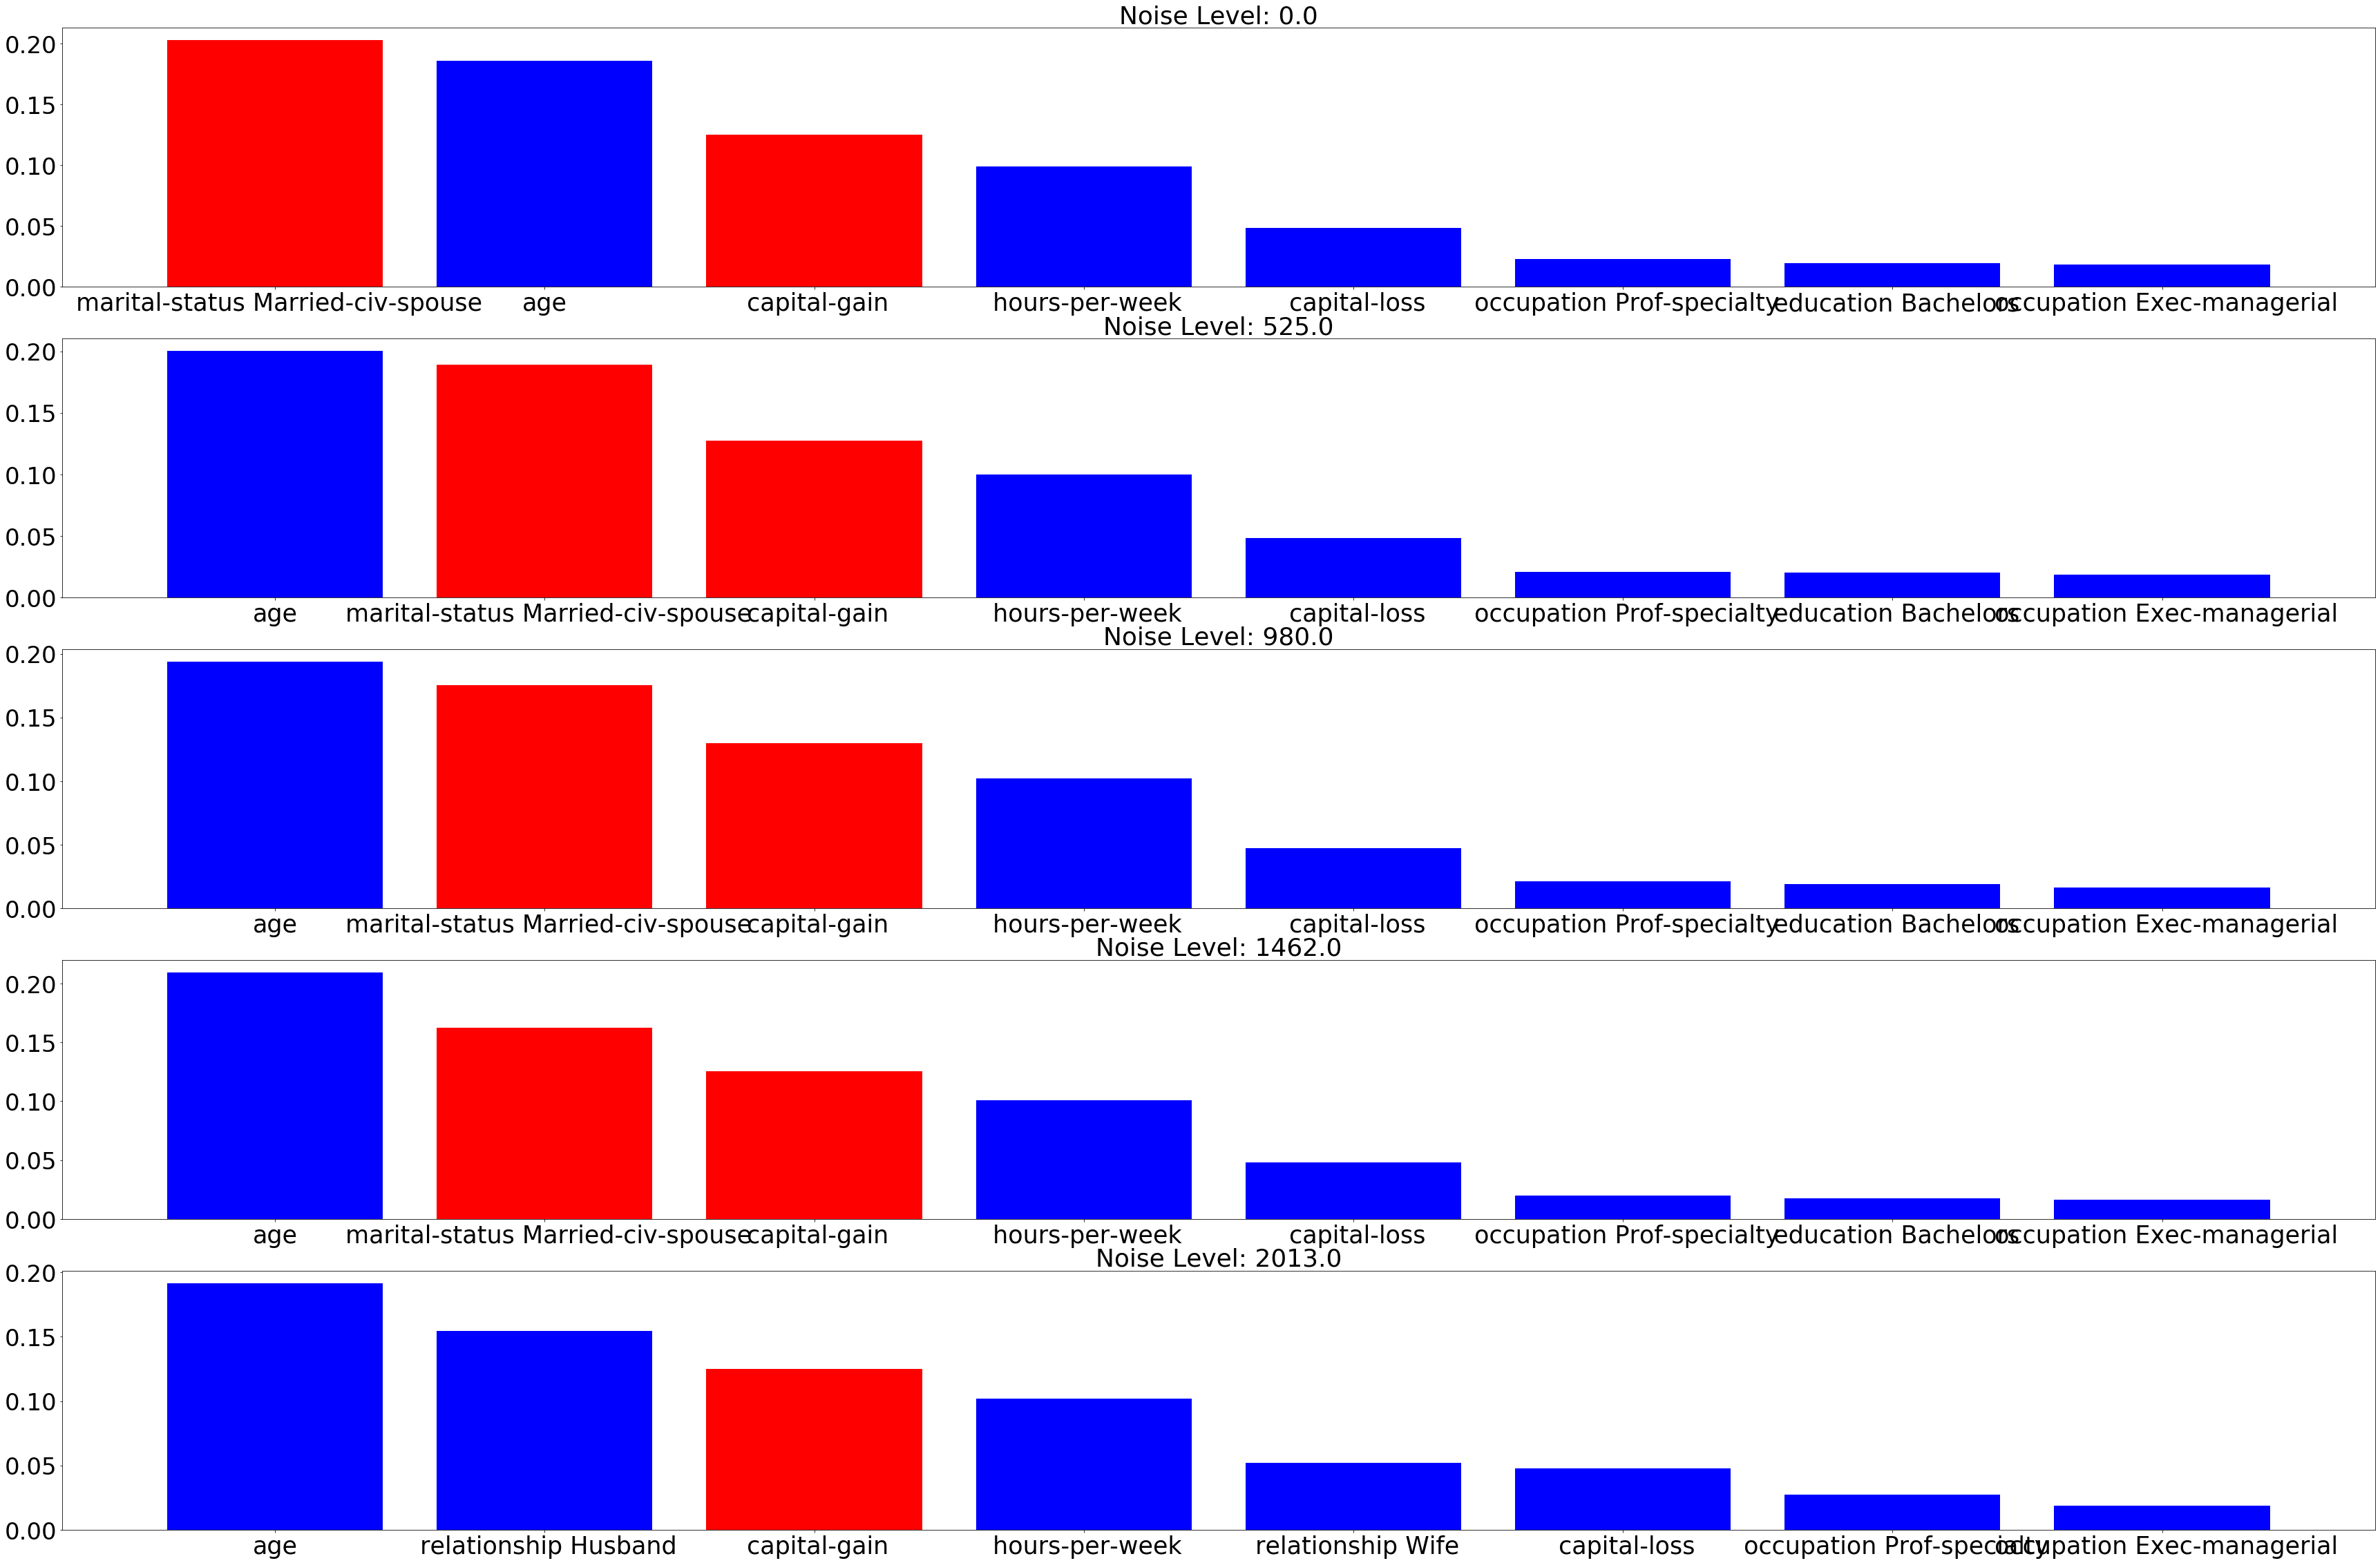

In [349]:
importance, score = noise_analysis(df, ylabel, features= ' marital-status Married-civ-spouse', overfit=True)
plot_importance(importance, [' marital-status Married-civ-spouse', ' capital-gain'])

We use parameters limits to deal with the tree overfitting:

/home/penalvad/conda/envs/aibase/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


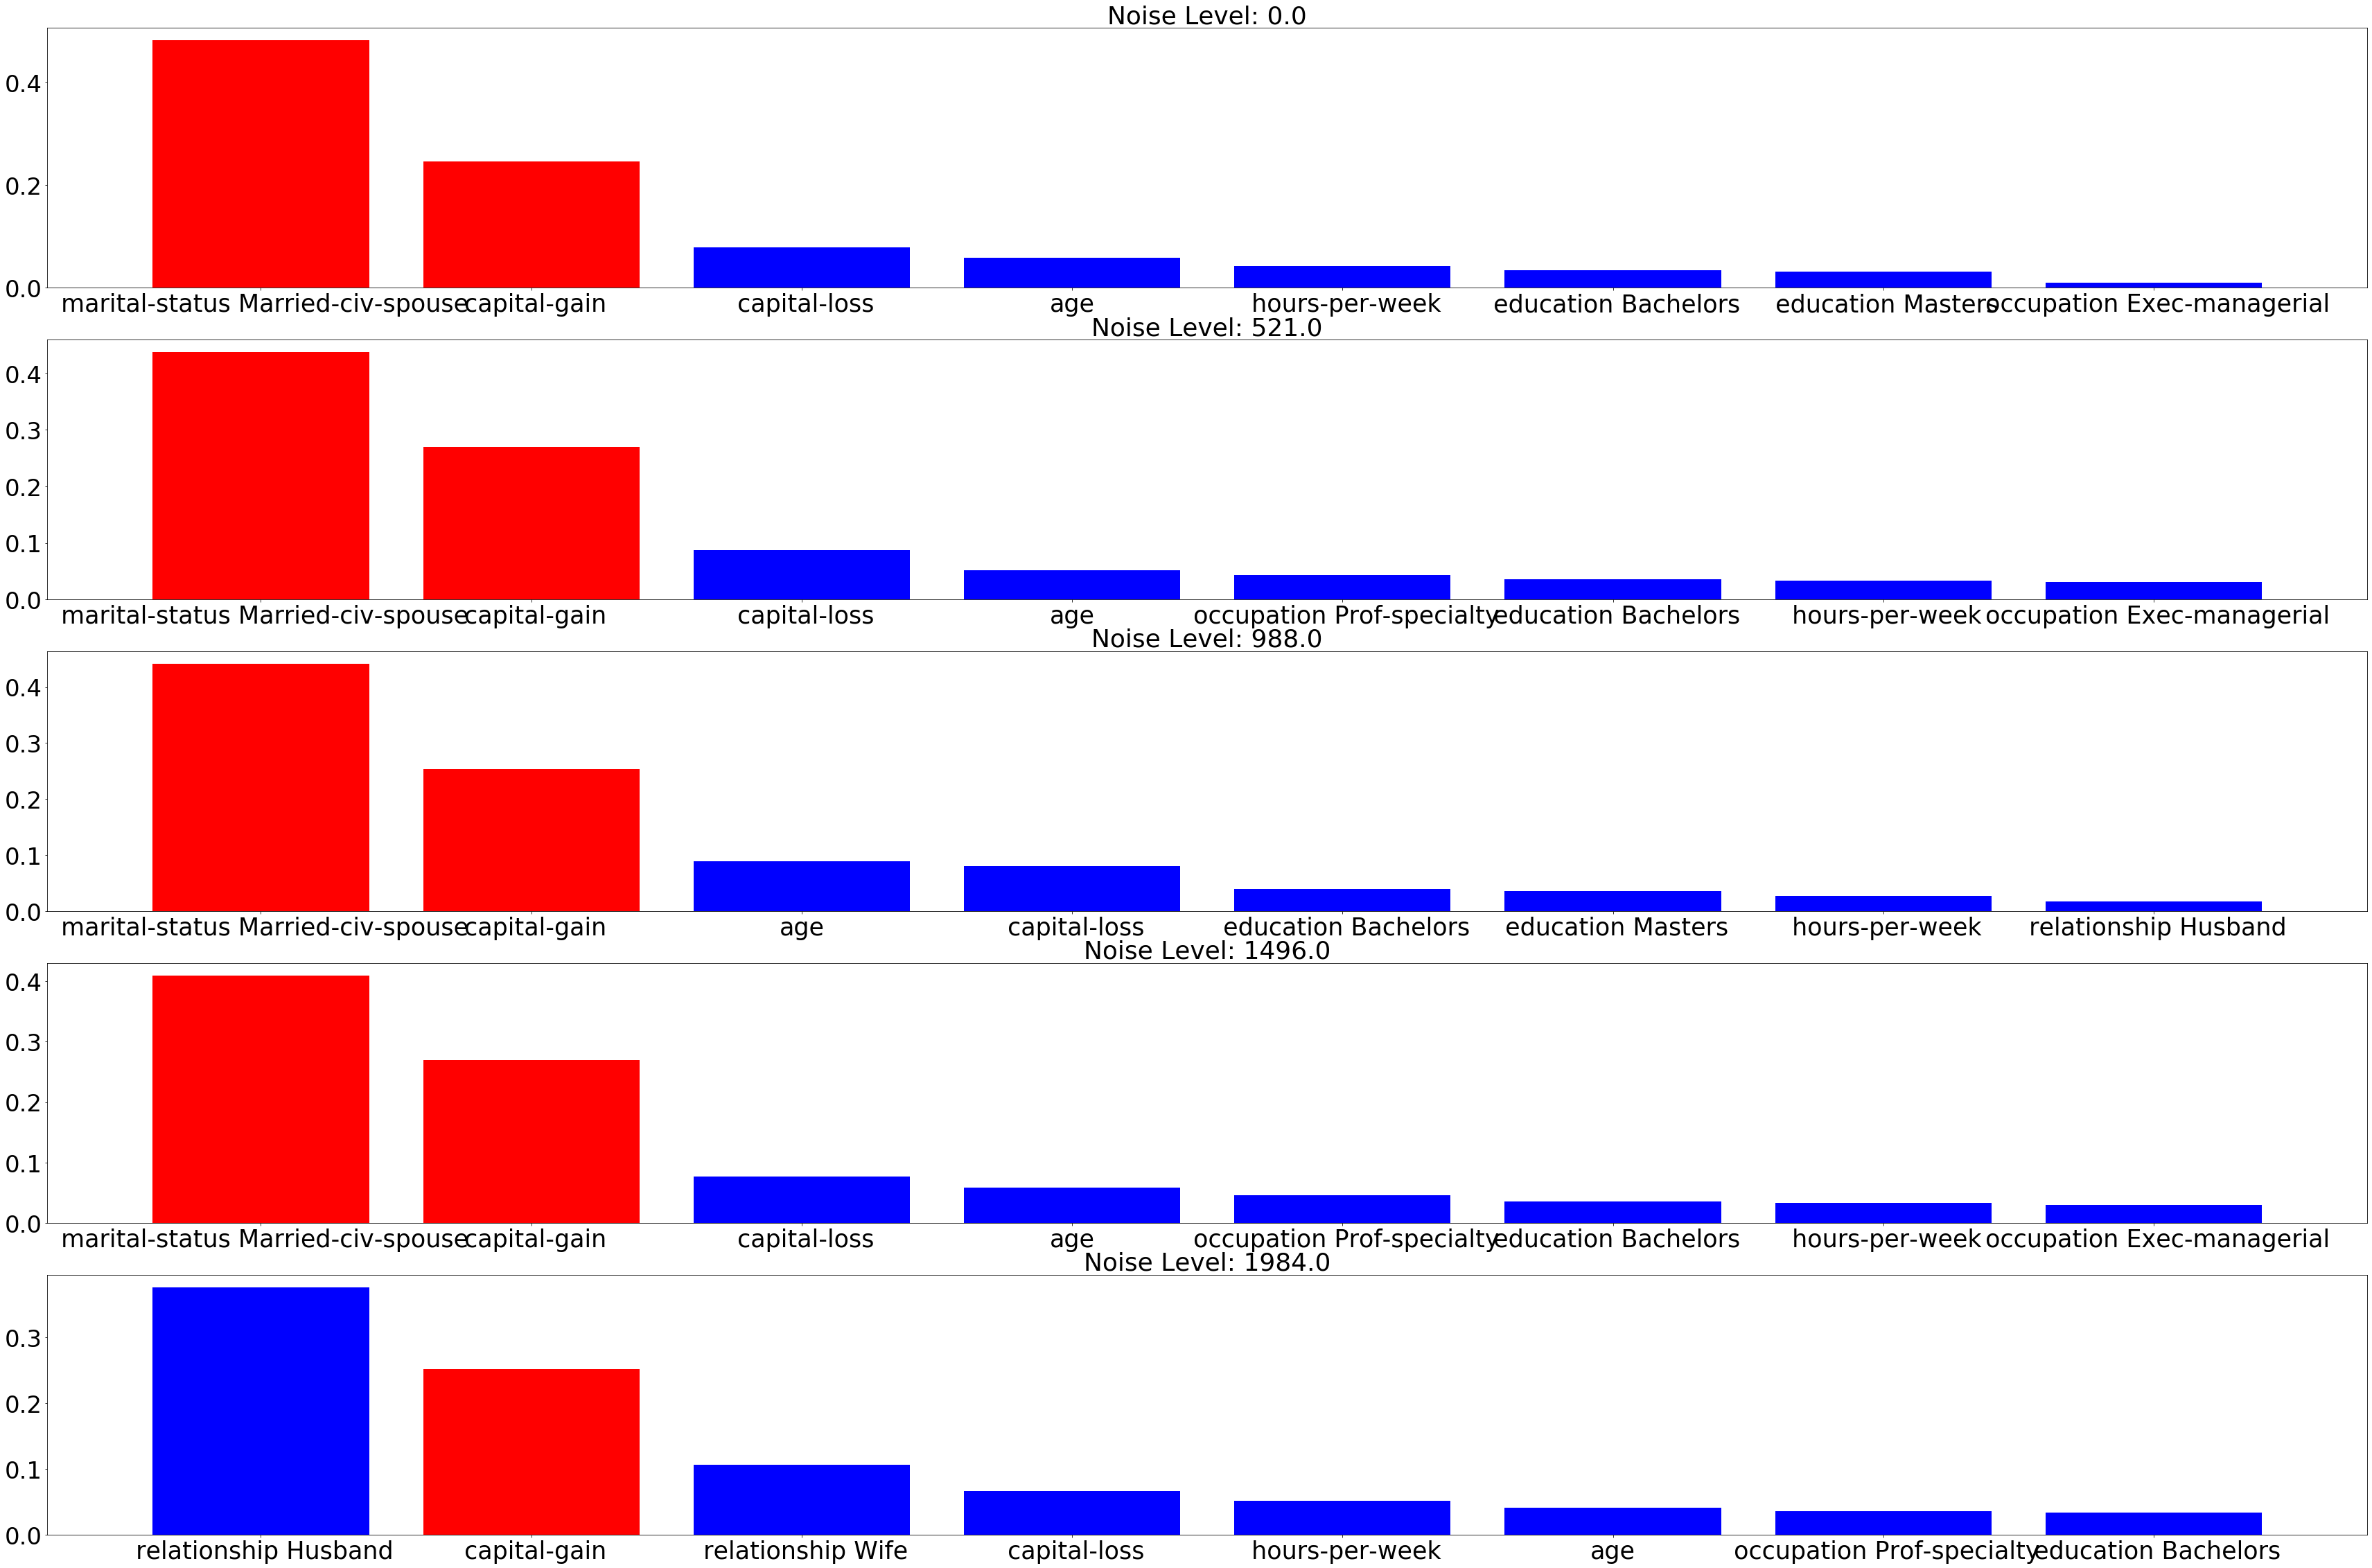

In [350]:
importance, score = noise_analysis(df, ylabel, features= ' marital-status Married-civ-spouse', overfit=False)
plot_importance(importance, [' marital-status Married-civ-spouse', ' capital-gain'])

Noise on numerical relevant features such ' capital gain':

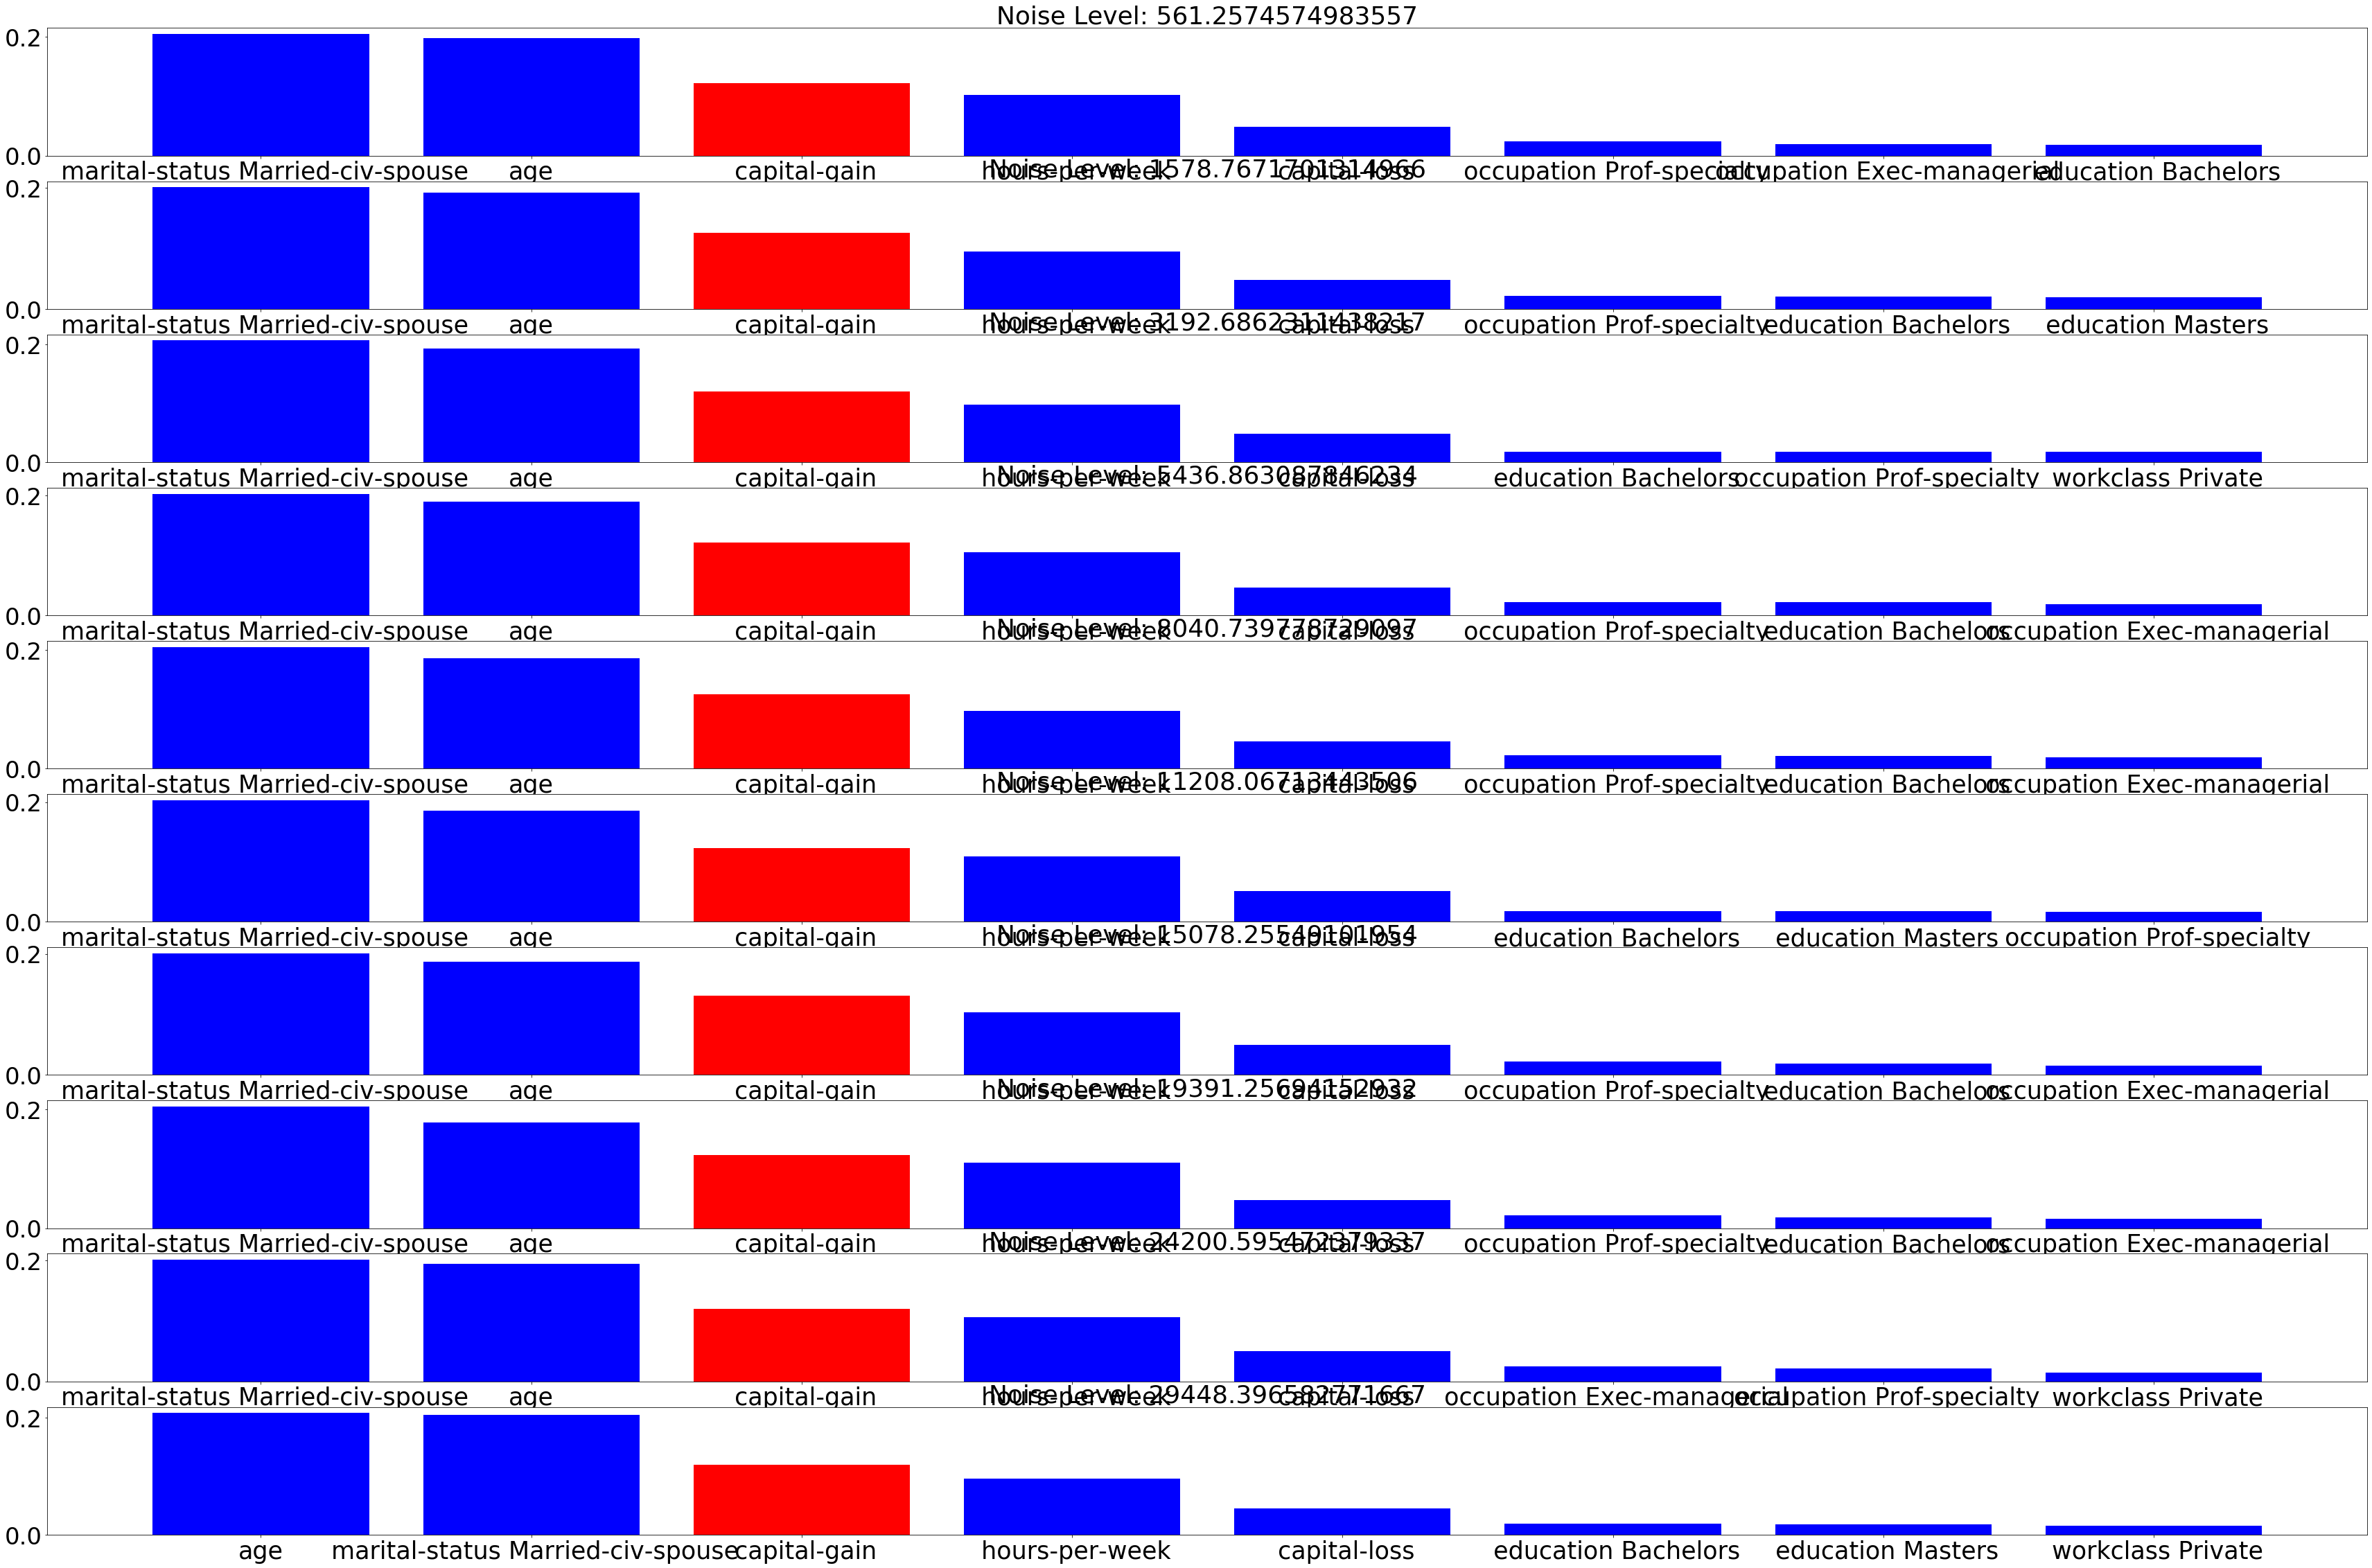

In [366]:
importance, score = noise_analysis(df, ylabel, features= ' capital-gain', feature_type='numerical', overfit=True)
plot_importance(importance, [' capital-gain'], nlevels=10)

In [223]:
# Noise in capital gain feature
df_noise = df.copy()
noise_level = []
acc = []
s = 30
noise=np.zeros(s)

for i in range(5,s):
    
  noise = np.random.randint(0,2**i,len(df[' capital-gain']))
  df_noise[' capital-gain']=df_noise[' capital-gain'] + noise
  Xnoise_train,Xnoise_holdout,ynoise_train,ynoise_holdout = train_test_split(df_noise, ylabel, test_size=0.3)
  noise_level.append(np.mean(np.abs(df_noise[' capital-gain']-df[' capital-gain'])))
  noise=np.zeros(s)
    
  tree = DecisionTreeClassifier(criterion='entropy',max_depth=6,min_samples_leaf=20, ccp_alpha=0.001, random_state=27)
  tree.fit(Xnoise_train, ynoise_train)
  yprednoise=tree.predict(Xnoise_holdout)
  acc.append(balanced_accuracy_score(ynoise_holdout,yprednoise))  
    
  importance=pd.DataFrame(columns=['features','importance'])
  importance['features']=df.columns
  importance['importance']=tree.feature_importances_
  print(importance.sort_values('importance',axis=0,ascending=False).iloc[0:20])
#df_noise['marital-status Married-civ-spouse'] = df[numerical]+np.random.randint(0,100,df[numerical].shape)

                              features  importance
31   marital-status Married-civ-spouse    0.484152
0                         capital-gain    0.248297
1                         capital-loss    0.085932
3                                  age    0.041315
22                 education Bachelors    0.037555
2                       hours-per-week    0.033914
25                   education Masters    0.030715
46           occupation Prof-specialty    0.030595
24                   education HS-grad    0.004228
40          occupation Exec-managerial    0.003296
77            native-country Guatemala    0.000000
76               native-country Greece    0.000000
72          native-country El-Salvador    0.000000
75              native-country Germany    0.000000
78                native-country Haiti    0.000000
74               native-country France    0.000000
79   native-country Holand-Netherlands    0.000000
73              native-country England    0.000000
69                 native-count

                              features  importance
31   marital-status Married-civ-spouse    0.518626
0                         capital-gain    0.192033
3                                  age    0.069872
40          occupation Exec-managerial    0.064440
46           occupation Prof-specialty    0.059376
2                       hours-per-week    0.031753
1                         capital-loss    0.026638
22                 education Bachelors    0.023125
10          workclass Self-emp-not-inc    0.007083
24                   education HS-grad    0.007053
79   native-country Holand-Netherlands    0.000000
78                native-country Haiti    0.000000
77            native-country Guatemala    0.000000
76               native-country Greece    0.000000
72          native-country El-Salvador    0.000000
74               native-country France    0.000000
73              native-country England    0.000000
75              native-country Germany    0.000000
68             native-country C

                              features  importance
31   marital-status Married-civ-spouse    0.582443
3                                  age    0.110531
46           occupation Prof-specialty    0.076485
22                 education Bachelors    0.066391
40          occupation Exec-managerial    0.052750
2                       hours-per-week    0.051023
1                         capital-loss    0.033184
25                   education Masters    0.011626
24                   education HS-grad    0.009821
28              education Some-college    0.005745
75              native-country Germany    0.000000
74               native-country France    0.000000
76               native-country Greece    0.000000
72          native-country El-Salvador    0.000000
77            native-country Guatemala    0.000000
78                native-country Haiti    0.000000
79   native-country Holand-Netherlands    0.000000
73              native-country England    0.000000
0                         capit

                              features  importance
31   marital-status Married-civ-spouse    0.579750
46           occupation Prof-specialty    0.100023
3                                  age    0.097765
2                       hours-per-week    0.077883
40          occupation Exec-managerial    0.073440
22                 education Bachelors    0.029923
1                         capital-loss    0.014078
24                   education HS-grad    0.008894
10          workclass Self-emp-not-inc    0.008581
27               education Prof-school    0.004931
28              education Some-college    0.004732
75              native-country Germany    0.000000
0                         capital-gain    0.000000
76               native-country Greece    0.000000
77            native-country Guatemala    0.000000
73              native-country England    0.000000
78                native-country Haiti    0.000000
79   native-country Holand-Netherlands    0.000000
74               native-country

## Noise in the label target

In [232]:
y_noise = ylabel.copy()
noise_level = []
acc = []
s = 32000
noise=np.zeros(s)

for i in range(0,s,1000):
  n = np.random.randint(0,2,i)
  for  j in range(i):
    noise[j] = noise[j] + n[j]
  y_noise.iloc[:s]=(y_noise.iloc[:s] + noise)%2
  Xnoise_train,Xnoise_holdout,ynoise_train,ynoise_holdout = train_test_split(df, y_noise, test_size=0.3)
  noise_level.append(np.sum(np.abs(y_noise.iloc[:s]-ylabel.iloc[0:s])))
  noise=np.zeros(s)
    
  tree = DecisionTreeClassifier(criterion='entropy',max_depth=6,min_samples_leaf=20, ccp_alpha=0.001, random_state=27)
  tree.fit(Xnoise_train, ynoise_train)
  yprednoise=tree.predict(Xnoise_holdout)
  acc.append(balanced_accuracy_score(ynoise_holdout,yprednoise))  
    
  importance=pd.DataFrame(columns=['features','importance'])
  importance['features']=df.columns
  importance['importance']=tree.feature_importances_
  print(importance.sort_values('importance',axis=0,ascending=False).iloc[0:20])

                              features  importance
31   marital-status Married-civ-spouse    0.474480
0                         capital-gain    0.243398
1                         capital-loss    0.082207
3                                  age    0.049313
46           occupation Prof-specialty    0.044049
22                 education Bachelors    0.036252
40          occupation Exec-managerial    0.032662
2                       hours-per-week    0.031704
24                   education HS-grad    0.005935
76               native-country Greece    0.000000
71              native-country Ecuador    0.000000
74               native-country France    0.000000
77            native-country Guatemala    0.000000
73              native-country England    0.000000
78                native-country Haiti    0.000000
72          native-country El-Salvador    0.000000
75              native-country Germany    0.000000
68             native-country Columbia    0.000000
70   native-country Dominican-R

                              features  importance
31   marital-status Married-civ-spouse    0.491460
0                         capital-gain    0.280022
1                         capital-loss    0.076017
40          occupation Exec-managerial    0.049183
46           occupation Prof-specialty    0.043791
2                       hours-per-week    0.033662
22                 education Bachelors    0.018952
3                                  age    0.006913
70   native-country Dominican-Republic    0.000000
78                native-country Haiti    0.000000
77            native-country Guatemala    0.000000
76               native-country Greece    0.000000
75              native-country Germany    0.000000
74               native-country France    0.000000
73              native-country England    0.000000
72          native-country El-Salvador    0.000000
71              native-country Ecuador    0.000000
68             native-country Columbia    0.000000
69                 native-count

                              features  importance
31   marital-status Married-civ-spouse    0.478629
0                         capital-gain    0.268649
1                         capital-loss    0.116342
46           occupation Prof-specialty    0.054637
22                 education Bachelors    0.051450
40          occupation Exec-managerial    0.030294
77            native-country Guatemala    0.000000
76               native-country Greece    0.000000
75              native-country Germany    0.000000
74               native-country France    0.000000
73              native-country England    0.000000
72          native-country El-Salvador    0.000000
71              native-country Ecuador    0.000000
70   native-country Dominican-Republic    0.000000
69                 native-country Cuba    0.000000
68             native-country Columbia    0.000000
79   native-country Holand-Netherlands    0.000000
67                native-country China    0.000000
66               native-country

                              features  importance
31   marital-status Married-civ-spouse    0.496070
0                         capital-gain    0.388666
22                 education Bachelors    0.115264
68             native-country Columbia    0.000000
77            native-country Guatemala    0.000000
76               native-country Greece    0.000000
75              native-country Germany    0.000000
74               native-country France    0.000000
73              native-country England    0.000000
72          native-country El-Salvador    0.000000
71              native-country Ecuador    0.000000
70   native-country Dominican-Republic    0.000000
69                 native-country Cuba    0.000000
67                native-country China    0.000000
79   native-country Holand-Netherlands    0.000000
66               native-country Canada    0.000000
65             native-country Cambodia    0.000000
64                    native-country ?    0.000000
63                            s

Label-Noise complete destroys the feature importance, accuracy turn out to be %50, that is, the tree is randomly classifying because the level of noise turn the label in random data.

In [115]:
X_train,X_holdout,y_train,y_holdout = train_test_split(df[numerical], ylabel, test_size=0.3)
Xnoise_train,Xnoise_holdout,ynoise_train,ynoise_holdout = train_test_split(df_noise, ylabel, test_size=0.3)

In [136]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=None,min_samples_leaf=10, random_state=27)
tree.fit(X_train, y_train)
ypred=tree.predict(X_holdout)
yprob=tree.predict_proba(X_holdout)
#tree_graph_to_png(tree=tree, feature_names=df_noise.columns,png_file_to_save='no_noise.png')

tree = DecisionTreeClassifier(criterion='entropy',max_depth=None,min_samples_leaf=10, random_state=27)
tree.fit(Xnoise_train, ynoise_train)
yprednoise=tree.predict(Xnoise_holdout)
yprobnoise=tree.predict_proba(Xnoise_holdout)
#tree_graph_to_png(tree=tree, feature_names=df_noise.columns,png_file_to_save='noise.png')

In [137]:
print(balanced_accuracy_score(y_holdout,ypred))
print(balanced_accuracy_score(ynoise_holdout,yprednoise))
print('Brier Loss Score')
print(brier_score_loss(y_holdout,yprob[:,0], pos_label=' <=50K'))
print(brier_score_loss(ynoise_holdout,yprob[:,0], pos_label=' <=50K'))

0.6702279813073729
0.6337866941988713
Brier Loss Score
0.12477481195537421
0.2515284722866653


Faltante neste notebook:
- Noise sensibility: terminar funçao def noise_analysis.
  - numerical (?) e target (?).